_Neural Data Science_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2022

Name: Leander Zimmermann, Harald Kugler

# Coding Lab 6



In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

mpl.rc("savefig", dpi=72)
sns.set_style('whitegrid')
%matplotlib inline

## Task: Implement entropy estimators




### General framework

Entropy is defined as 

$$
H[p] = -\sum_x p_x \log p_x
$$

where $p_x = p(x=X)$. Here we assume that $X$ is a discrete random variable and that there are finitely many states $K$ that $X$ can take.

We are interested in the entropy of discrete random variables, because of its relationship with mutual information:

$$
I[X|Y] = H[X] - H[X|Y]
$$

If we can estimate the entropy well, we can estimate the mutual information well. An application in neuroscience would be estimating the mutual information between a spike train modeled as a sequence of $1$ s and $0$ s (e.g. $(0,1,0,1,1)$) and a discrete set of stimuli.

Note that a multivariate binary distribution modeling a spike train can always be mapped to a discrete univariate distribution, $\mathbb{Z}_2 \longrightarrow \mathbb{Z_+}$, by interpreting each binary state $z \in \mathbb{Z}_2$ as its corresponding binary number and computing $f(z) = \sum_i 2^{i} z_i$.

As discussed in the lecture, the problem is that one always underestimates the true entropy of a distribution from samples. In this exercise you are meant to implement different estimators for discrete entropy and evaluate them on different discrete distributions:

* Uniform distribution: $p(x=X) = \frac{1}{K}$

* "Zipf's law"- distribution: $p(x=X) = \frac{1}{Z x} $, where $Z = \sum_k 1/k$

There is a really good series of blog posts about discrete entropy estimation to be found [here](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-1.html), [here](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-2.html) and [here](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-3.html). 

Make sure you use binary logarithms throughout.


### Implementation of the estimators

Implement the

* maximum likelihood estimator (1 pt)
* miller-maddow corrected estimator (1 pt)
* jack-knife corrected estimator (2 pt)
* coverage adjusted estimator (1 pt).

When implementing the jack-knife estimator, you may want to restrict the amount of resampling for performance reasons e.g. to 1000, even if more samples are available. By definition, $0\log0=0$. Adapt the interfaces as needed for your implementation.

In addition, implement or use one of the following more advanced estimators (1+3 pts, extra points if you use your own implementation):

* [JVHW estimator](https://arxiv.org/abs/1406.6956) with code on [github](https://github.com/EEthinker/JVHW_Entropy_Estimators/tree/master/Python)
* [Unseen estimator](http://papers.nips.cc/paper/5170-estimating-the-unseen-improved-estimators-for-entropy-and-other-properties) (includes Matlab code in Supplementary)
* [Best Upper Bounds estimator](http://www.mitpressjournals.org/doi/abs/10.1162/089976603321780272) (Matlab code available on Ilias)

For this part, you are allowed to use an existing implementation as well.


## MLE

$H_{ML}= -\sum_{x}\hat{p}(x)log(\hat{p}(x))$

In [16]:
def entropy_mle(phat):
    '''Maximum likelihood or plug-in estimator of discrete entropy
    
    Parameter
    ---------
    
    phat: np.array, shape=(n_bins, )
        Estimate of the distribution / histogram
    
    Return
    ------
    H: float
        Entropy estimate
    '''
    # Check that the estimate is a valid probability distribution
    assert np.all(phat >= 0), "Probabilities must be non-negative"
    assert np.all(phat <= 1), "Probabilities must be less than 1"
    assert np.isclose(np.sum(phat), 1), "Probabilities must sum to 1"

    # Replace zeros with small value to avoid NaNs
    phat = phat[phat != 0] 
    
    # Compute entropy
    H = -np.sum(phat * np.log2(phat))
    
    return H


## Miller-Maddow corrected

$H_{MM}=H_{ML}+\frac{\hat{d}-1}{2n}$ 

$ \hat{d} = \#[\hat{p}(x)>0]$ 



In [17]:
def entropy_mm(phat, n):
    '''Miller-Maddow corrected estimator of discrete entropy
    
    Parameters
    ----------
    
    phat: np.array, shape=(n_bins, )
        Estimate of the distribution / histogram
        
    n:  int
        Number of samples
    

    Return
    ------
    
    H: float
        Entropy estimate
    '''

    # Check that the estimate is a valid probability distribution
    assert np.all(phat >= 0), "Probabilities must be non-negative"
    assert np.all(phat <= 1), "Probabilities must be less than 1"
    assert np.isclose(np.sum(phat), 1), "Probabilities must sum to 1"

    # Compute dhat
    dhat = np.sum(phat > 0)

    # Compute entropy
    H = entropy_mle(phat) + (dhat / (2 * n))

    
    return H


## Jack-knife corrected

$\hat{H}_{JK} = N\hat{H}_{ML} - (N-1)\hat{H}_{ML}^{(.)}$ 

$\hat{H}_{ML}^{(.)} = <H_{ML}^{\lnot i}>$

In [18]:
def entropy_jk(x, edges):
    '''Jack-knife corrected estimator of discrete entropy
    
    Parameters
    ----------
    x: np.array, shape=(n_samples, )
        Samples
        
    edges: np.array, shape=(n_bins, )
        Histogram bin edges
    
    
    Return
    ------
    
    H: float
        Entropy estimate
    '''

    N = len(x)

    # compute hhat_jk
    Hhat_jk = []
    index = np.arange(N)
    for i in range(np.min([N, 1000])):
        phat_jk, _ = np.histogram(x[index!=i], edges, density=True)
        Hhat_jk.append(entropy_mle(phat_jk))
    
    # compute Hhat
    phat, _ = np.histogram(x, edges, density=True)
    Hhat = entropy_mle(phat)
    
    # compute H
    H = N * Hhat - (N - 1) * np.mean(Hhat_jk)
    
    return H

## Coverage-adjusted

$C = 1 - \frac{\# f_{i}=1}{N}$

$\hat{P}_{C}= \hat{P}\cdot C$ 

$H_{CA}= -\sum_{x}\frac{\hat{P_{C}}(x)log(\hat{P_{C}}(x))}{1-(1-\hat{P_{C}}(x))^N}$



In [19]:
def entropy_cae(phat, n):
    '''coverage-adjusted estimator of discrete entropy
    
    Parameters
    ----------
    
    phat: np.array, shape=(n_bins, )
        Estimate of the distribution / histogram
        
    n: int
        Number of samples.
    
    
    Return
    ------
    
    H: float
        Entropy estimate
    '''
    # Compute C 
    C = 1-np.sum((phat*n) ==1) / n
    phat_c = phat * C
    phat_c = phat_c[phat_c != 0] 
    
    H = - np.sum((phat_c * np.log2(phat_c)) / (1-(1-phat_c)**n))
    
    return H

# JVHW

In [20]:
import est_entro as ee

def entropy_jvhw(x):
    '''JVHW estimator of discrete entropy.
        
    Parameter
    ---------
    x: np.array, shape=(n_samples, )
        Samples
        
    Return
    ------
    H: float
        Entropy estimate
    '''

    # insert your code here (1 pt)
    H = ee.est_entro_JVHW(x)[0] 
    
    return H

# Optional: Unseen or Best Upper Bounds estimator

In [21]:
# insert your code here 

# ------------------------------------------
# Port Unseen or Best Upper Bounds estimator
# from MatLab to Python. (3 bonus pts)
# ------------------------------------------


### Uniform distribution

In [22]:
D = 10
N = 2**D

p = 1/N * np.ones(N)   # true distribution

H = - np.sum(p * np.log2(p))  # true entropy

print(H)

10.0


Sample from the uniform distribution using sample sizes of 100 and 10000. Plot the true distribution and the sampled distributions. What do you notice? (2 pt)

**Answer:** Larger sample size yields a better approximation of the true density function. To be fair: it is impossible to approximate the true density function of the given uniform distribution with only 100 samples.

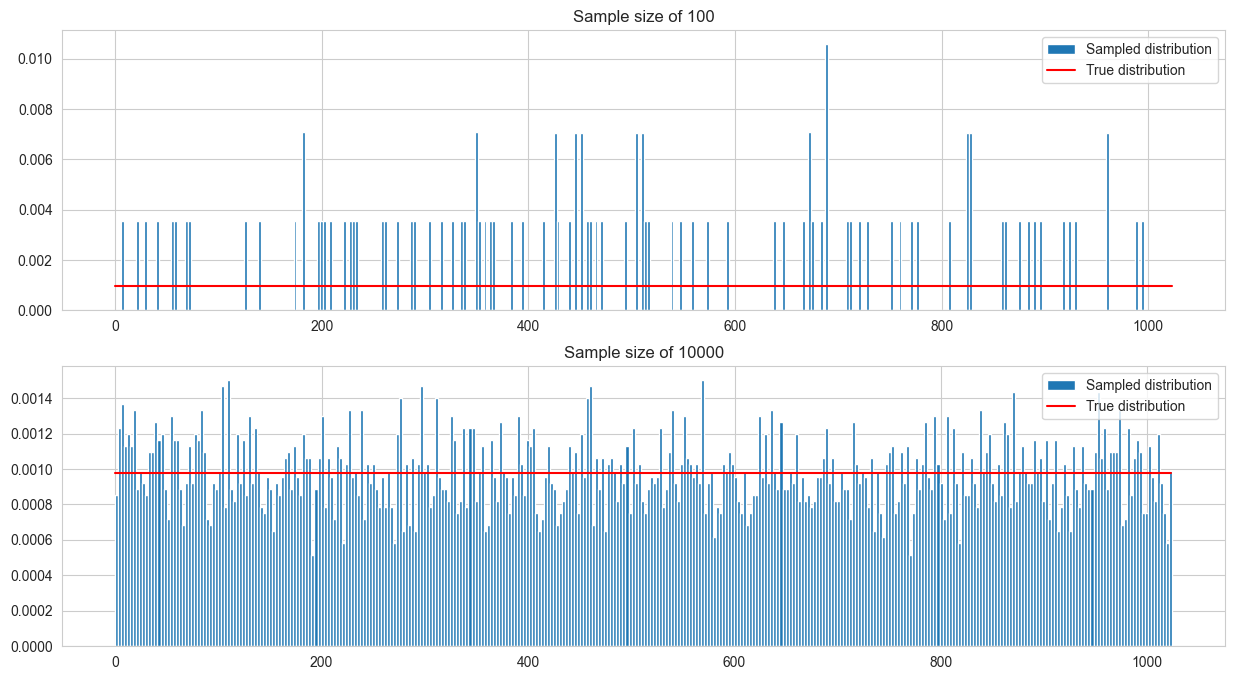

In [23]:
# ------------------------------------
# Sample from the uniform distribution
# using sample size of 100 (0.5 pts)
# ------------------------------------

samples_100 = np.random.uniform(0, N, 100)

# ------------------------------------
# Sample from the uniform distribution
# using sample size of 10000 (0.5 pts)
# ------------------------------------

samples_10k = np.random.uniform(0, N, 10000)

# ------------------------------------
# Plot the true distribution and 
# the sampled distributions. (0.5 pts)
# ------------------------------------

fig, axs = plt.subplots(2, 1, figsize=(15, 8))

axs[0].hist(samples_100, bins=350, density=True, label='Sampled distribution')
axs[0].set_title('Sample size of 100')
axs[0].plot(p, 'r', label='True distribution')
axs[0].legend()

axs[1].hist(samples_10k, bins=350, density=True, label='Sampled distribution')
axs[1].set_title('Sample size of 10000')
axs[1].plot(p, 'r', label='True distribution')
axs[1].legend()


plt.show()



Use the framework below to generate samples of different size (logarithmically spaced between 10 and 100000) and evaluate the different entropy estimators for multiple runs.

In [24]:
sample_sizes = np.round(np.logspace(1,5,num=10))
n_runs = 30

edges = np.arange(-0.5, N, 1)

h_mle  = np.zeros((len(sample_sizes), n_runs))
h_mm   = np.zeros((len(sample_sizes), n_runs))
h_jk   = np.zeros((len(sample_sizes), n_runs))
h_cae  = np.zeros((len(sample_sizes), n_runs))
h_jvhw = np.zeros((len(sample_sizes), n_runs))

# add h_unseen or h_bub here if you implemented them.

for i, S in enumerate(sample_sizes):
    for j in np.arange(n_runs):
        # ------------------------------------
        # Sample from the uniform distribution
        # with different sample size (0.5 pts)
        # ------------------------------------  
        x = np.random.uniform(0, N, int(S))
        phat, _ = np.histogram(x, bins=edges, density=True)
         
        # insert your code here
        h_mle[i,j]  = entropy_mle(phat)
        h_mm[i,j]   = entropy_mm(phat, S)
        h_cae[i,j]  = entropy_cae(phat, S)
        h_jk[i,j]   = entropy_jk(x, edges)
        h_jvhw[i,j] = entropy_jvhw(x.astype(int))

Plot the resulting average estimate of the entropy for each of the estimators. Which is best? If you implemented everything correctly, this plot should roughly look like in the lecture.

**Answer:** JVHW is best because it converges the fastest.

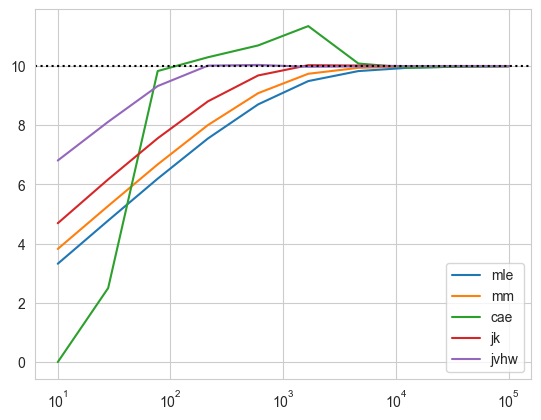

In [25]:
plt.figure()

plt.semilogx(sample_sizes, np.mean(h_mle,  axis=1), label='mle')
plt.semilogx(sample_sizes, np.mean(h_mm,   axis=1), label='mm')
plt.semilogx(sample_sizes, np.mean(h_cae,  axis=1), label='cae')
plt.semilogx(sample_sizes, np.mean(h_jk,   axis=1), label='jk')
plt.semilogx(sample_sizes, np.mean(h_jvhw, axis=1), label='jvhw')

# plot h_unseen or h_bub here if you implemented them.

plt.axhline(H, color='black', linestyle=':')

plt.legend()


### Zipf distribution

[Zipf's law ](https://en.wikipedia.org/wiki/Zipf%27s_law) refers to a family of power law like distributions for which $p_k \sim 1/k^d$. We will simply use $d=1$ here.   

Adapt the framework above to sample from a Zipf distribution and evaluate the estimators for this case. Are there differences to the uniform case? (2 pts)

In [26]:
D = 10
N = 2**D

p = 1/(np.arange(0,N)+1)    # true distribution
p = p/np.sum(p)

H = - np.sum(p * np.log2(p))  # true entropy

print(H)

7.510649703297878


Sample from the Zipf distribution using sample sizes of 100 and 10000. In this case, the function `random.choice` is very helpful for sampling. Plot the true distribution and the sampled distributions. What do you notice? 

**Answer:** More samples reflect the true distribution much better.

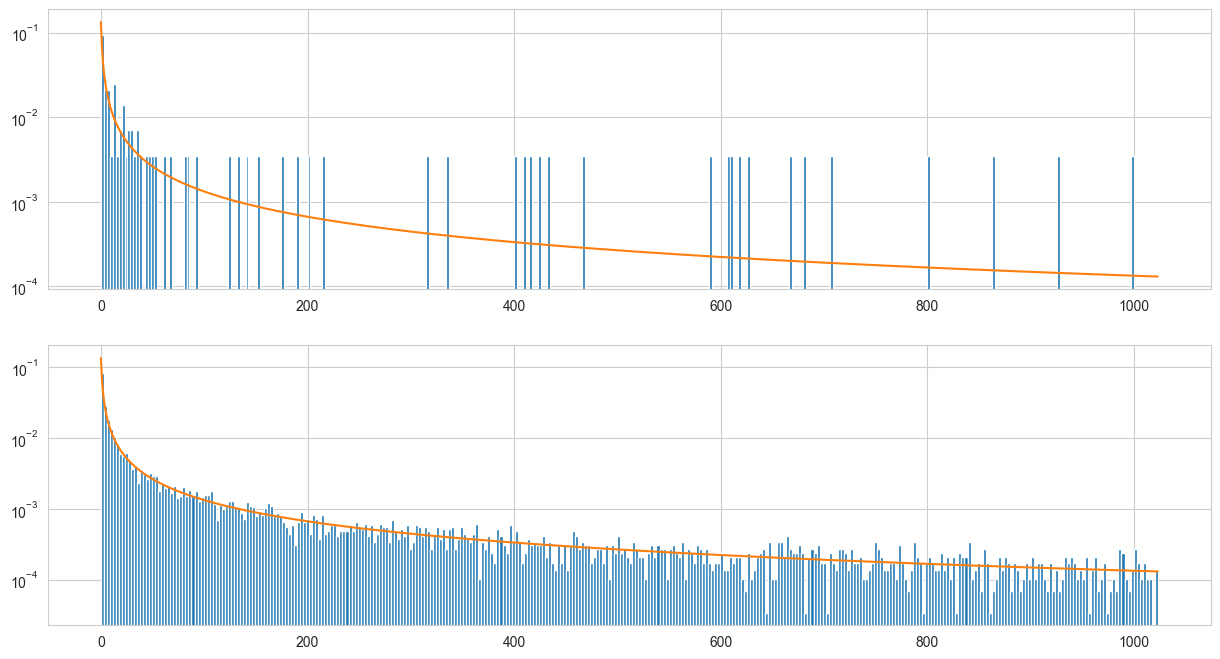

In [27]:
# insert your code here 

# ---------------------------------------
# Sample from the Zipf distribution
# using sample size of 100 (0.5 pts)
# ---------------------------------------

x_100 = np.random.choice(np.arange(0,N), 100, p=p)

# ---------------------------------------
# Sample from the Zipf distribution
# using sample size of 10000 (0.5 pts)
# ---------------------------------------
x_10000 = np.random.choice(np.arange(0,N), 10000, p=p)

# ---------------------------------------
# Plot the true distribution and the sampled
# distributions. (0.5 pts)
# ---------------------------------------

fig, axs = plt.subplots(2, 1, figsize=(15, 8))

axs[0].hist(x_100, bins=350, density=True)
axs[0].plot(np.arange(N), p, label='true distribution')

axs[1].hist(x_10000, bins=350, density=True)
axs[1].plot(np.arange(N), p, label='true distribution')

#set y scale
axs[0].set_yscale('log')
axs[1].set_yscale('log')


plt.show()


Use the framework below to generate samples of different size (logarithmically spaced between 10 and 100000) and evaluate the different entropy estimators for multiple runs.

In [28]:
sample_sizes = np.round(np.logspace(1,5,num=10))
n_runs = 30

edges = np.arange(-0.5, N, 1)

h_mle  = np.zeros((len(sample_sizes), n_runs))
h_mm   = np.zeros((len(sample_sizes), n_runs))
h_jk   = np.zeros((len(sample_sizes), n_runs))
h_cae  = np.zeros((len(sample_sizes), n_runs))
h_jvhw = np.zeros((len(sample_sizes), n_runs))

# add h_unseen or h_bub here if you implemented them.

for i, S in enumerate(sample_sizes):
    for j in np.arange(n_runs):
    
        # ---------------------------------------
        # Sample from the Zipf distribution
        # with different sample size (0.5 pts)
        # ---------------------------------------
        x = np.random.choice(np.arange(0, N), int(S), p=p)
        phat, _ = np.histogram(x, bins=edges, density=True)

        
        h_mle[i,j]  = entropy_mle(phat)
        h_mm[i,j]   = entropy_mm(phat, S)
        h_cae[i,j]  = entropy_cae(phat, S)
        h_jk[i,j]   = entropy_jk(x, edges)
        h_jvhw[i,j] = entropy_jvhw(x)


Plot resulting average estimate of the entropy for each of the estimators. Which is best? If you implemented everything correctly, this plot should roughly look like in the lecture.

**Answer:** Like above JVHW converges the fastest. Thus it is the best.

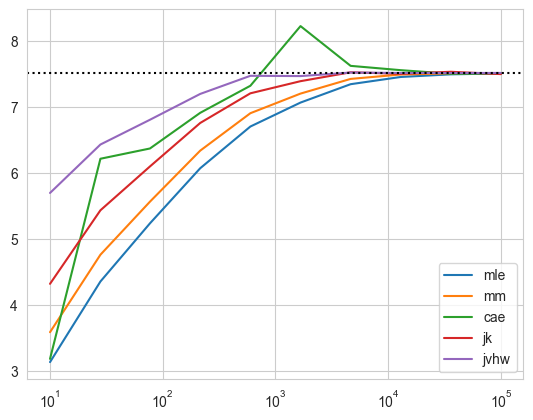

In [29]:
plt.figure()

plt.semilogx(sample_sizes, np.mean(h_mle,  axis=1), label='mle')
plt.semilogx(sample_sizes, np.mean(h_mm,   axis=1), label='mm')
plt.semilogx(sample_sizes, np.mean(h_cae,  axis=1), label='cae')
plt.semilogx(sample_sizes, np.mean(h_jk,   axis=1), label='jk')
plt.semilogx(sample_sizes, np.mean(h_jvhw, axis=1), label='jvhw')

# plot h_unseen or h_bub here if you implemented them.

plt.axhline(H, color='black', linestyle=':')
plt.legend()

plt.show()

